# DSI Instructor Tasks
#### By Mahdi Shadkam-Farrokhi (mahdis.pw@gmail.com)


## Table of Contents

__[Part 1: Modeling Challenge](#Part-1:-Modeling-Challenge)__
- [Loading Libraries & Data](#Loading-Libraries-&-Data)
    - [Steps I might take to evaluate or transform the dataset](#Steps-I-might-take-to-evaluate-or-transform-the-dataset)
- [Exploring smoothness and compactness for benign and malignant tumors](#Exploring-smoothness-and-compactness-for-benign-and-malignant-tumors)
- [Generating Bootstrapped Datasets](#Generating-Bootstrapped-Datasets)
    - [Transforming target variable to binary integers](#Transforming-target-variable-to-binary-integers)
    - [Feature & Target correlation](#Feature-&-Target-correlation)
- [Model Preparation](#Model-Preparation)
    - [Metric of choice: _Recall_](#Metric-of-choice:-Recall)
- [Decision Tree](#Decision-Tree)
- [K Nearest Neighbors (KNN)](#K-Nearest-Neighbors-(KNN))
- [Model Selection](#Model-Selection)
    - [Technical Explaination](#Technical-Explaination)
    - [Non-Technical Explaination](#Non-Technical-Explaination)

__[Part 2: Student Feedback Challenge](#Part-2:-Student-Feedback-Challenge)__
- [Student #1 (Amy)](#Student-#1-(Amy))
- [Student #2 (Billy)](#Student-#2-(Billy))


# Part 1: Modeling Challenge

## Loading Libraries & Data

In [410]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = sum([ord(letter) for letter in "Mahdi Shadkam-Farrokhi"])

In [411]:
header_file = "./data/field_names.txt"
cancer_file = "./data/breast-cancer.csv"

header_df = pd.read_csv(header_file, sep="\n", header=None)
header = headers_df.iloc[:,0]

data = pd.read_csv(cancer_file, header = None, names = header, index_col = "ID")

target = "diagnosis"

In [412]:
data.head()

,diagnosis,radius_mean,radius_sd_error,radius_worst,texture_mean,texture_sd_error,texture_worst,perimeter_mean,perimeter_sd_error,perimeter_worst,...,concavity_worst,concave_points_mean,concave_points_sd_error,concave_points_worst,symmetry_mean,symmetry_sd_error,symmetry_worst,fractal_dimension_mean,fractal_dimension_sd_error,fractal_dimension_worst
ID,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Steps I might take to evaluate or transform the dataset

Evaluation steps
- check for null values
- check for duplicate rows
- check for proper feature data types
- check for proper range of values and category proportions
- check for collinearity
- check for correlation with target variable

Transformation steps
- Convert ordinal categorical features (map categories to integers)
- Convert nominal categorical features (one-hot encoding - dummy variables)
- engineering features

## Exploring smoothness and compactness for benign and malignant tumors

In [413]:
def draw_boxplot(feature):
    '''Given a feature column name, a boxplot is drawn broken down by diagnosis.'''
    sizing = 16
    readable_feature = " ".join([word.capitalize() for word in feature.split("_")])
    plt.figure(figsize=(10,8))
    plt.title(f"Distribution of {readable_feature} by Diagnosis", fontsize = sizing * 1.4 , pad = sizing)
    g = sns.boxplot(data = data, x = target, y = feature, showfliers=False, palette = "Set2")
    g.set_xlabel("Diagnosis", fontsize = sizing)
    g.set_ylabel(readable_feature, fontsize = sizing)
    g.set_xticklabels(["Malignant", "Benign"])

#### Evaluating `smoothness_mean`

In [414]:
data.groupby(target)["smoothness_mean"].describe()[["mean","50%"]]

,mean,50%
diagnosis,,
B,2.000321,1.8510
M,4.323929,3.6795


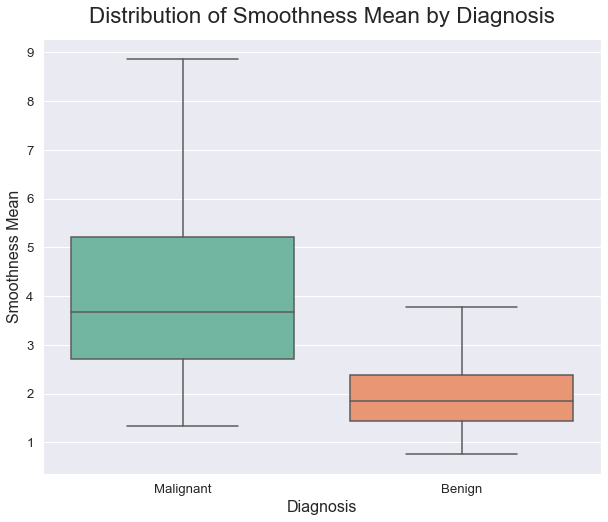

In [415]:
draw_boxplot("smoothness_mean")

We find "Benign" tumors have a mean smoothness of 2 and a median of about 1.85, which suggests a relatively normal distribution with a slight right skew.

On the other hand, "Malignant" tumors have a larger mean smoothness of 4.3 and a median of 3.68, suggesting a much heavier right skew to its distribution.

#### Evaluating `compactness_mean`

In [416]:
data.groupby(target)["compactness_mean"].describe()[["mean","50%"]]

,mean,50%
diagnosis,,
B,0.021438,0.01631
M,0.032281,0.02859


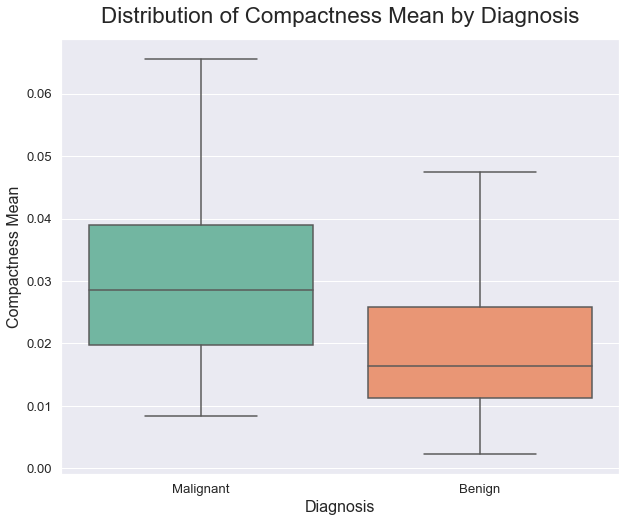

In [417]:
draw_boxplot("compactness_mean")

We find "Benign" tumors have a mean compactness of .021 and a median of about .016, which suggests a distribution with a strong skew to the right. "Malignant" tumors have a similiar distribution, but with a mean compactness of .032 and a median of .029.

## Generating Bootstrapped Datasets

In [418]:
data.duplicated().sum()

0

The original dataset has no duplicate observations

In [419]:
def bootstrap_df(df, n = 10):
    '''Returns a list of length n where each element is a new dataframe bootstrapped from the given dataframe.'''
    length = df.shape[0]
    return [df.sample(n = length, replace = True) for _ in range(n)]

In [420]:
bootstrapped_dfs = bootstrap_df(data)

# showing counts of duplicates from each bootstrapped dataframe
[df.duplicated().sum() for df in bootstrapped_dfs]

[198, 215, 213, 218, 197, 206, 211, 212, 198, 209]

The bootstrapped datasets show duplicated observations.
This is to be expected, since observations can be resampled (sampling with replacement).

### Transforming target variable to binary integers
I'll treat "Malignant" as the focus, converting it to 1, and "Benign" to 0.

In [421]:
data[target] = data[target].map({"M":1,"B":0})

In [422]:
data[target].value_counts(normalize = True)

0    0.627417
1    0.372583
Name: diagnosis, dtype: float64

We find a slight classification imbalance, with "Malignant" observations taking up a little over 1/3 of the dataset, while "Benign" takes up the other two-thirds.

If we were using accuracy as our metric, this would effectively serve as our baseline model accurary (where every prediction is 0, or "Benign").

### Feature & Target correlation

In [423]:
target_corrs = data.corr()[target]

# taking negative correlations into account
target_corrs[np.abs(target_corrs).sort_values(ascending = False)[1:6].index]

fractal_dimension_mean     0.793566
concave_points_sd_error    0.782914
perimeter_sd_error         0.776614
concavity_worst            0.776454
radius_worst               0.742636
Name: diagnosis, dtype: float64

The top 5 variables with the highest correlation with malgnant tumors are: `fractal_dimension_mean`, `concave_points_sd_error`, `perimeter_sd_error`, `concavity_worst`, and `radius_worst`.

#### Evaluating `fractal_dimension_mean`

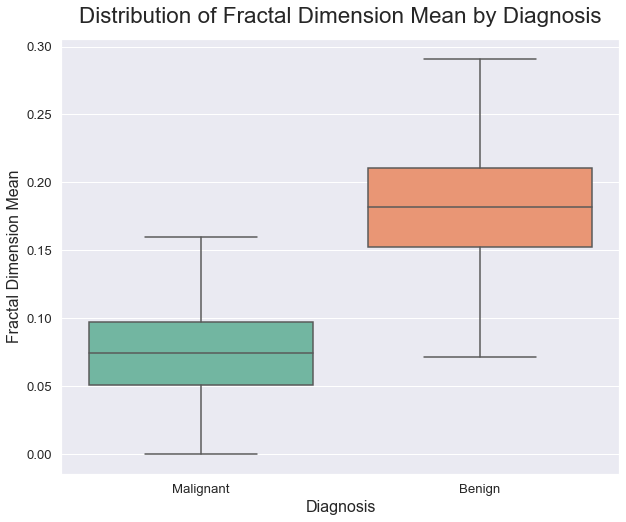

In [424]:
draw_boxplot("fractal_dimension_mean")

The most substantial feature correlated with malignant tumors is `fractal_dimension_mean` and its distribution clearly shows the stark difference between the "Malignant" and "Benign" diagnosis, with "Malignant" tumors having a smaller `fractal_dimension_mean` on average than "Benign" tumors.

#### Evaluating `concave_points_sd_error`

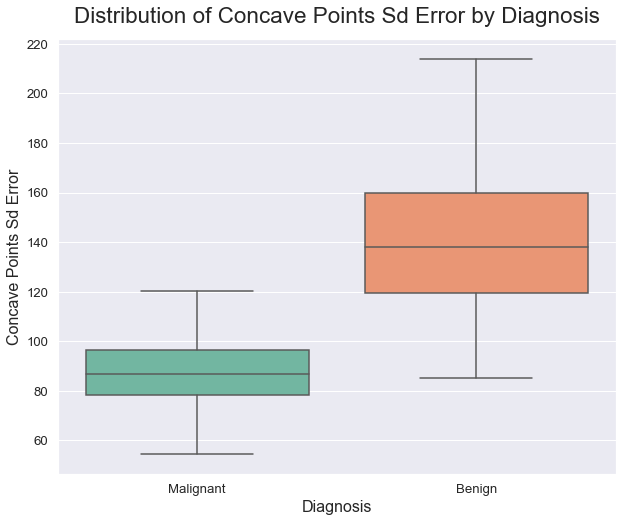

In [425]:
draw_boxplot("concave_points_sd_error")

The next more correlated feature is `concave_points_sd_error` and follows a similar pattern in its distribution. We see a clear difference between the "Malignant" and "Benign" diagnosis on average, with "Malignant" tumors having a smaller `concave_points_sd_error` than "Benign" tumors.

#### Evaluating `perimeter_sd_error`

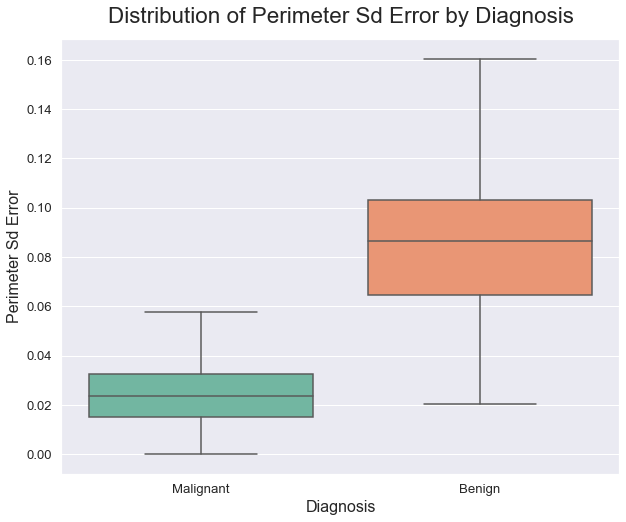

In [426]:
draw_boxplot("perimeter_sd_error")

Following suit, the third most correlated feature is `perimeter_sd_error`. Like the previous features showed, "Malignant" tumors having a smaller `perimeter_sd_error` than "Benign" tumors.

## Model Preparation

### Metric of choice: _Recall_
Given the problem involves health outcomes, I'm choosing to use _recall_ as my preferred metric of choice.  
This will help reduce false negatives, since my focus `diagnosis` is "Malignant" (as 1).  

In practice, a patient being flagged as "Benign", when they actually have a malignant tumor is much more devestating than being flagged as "Malignant" and running more tests to confirm the diagnosis.

In [427]:
X = data.drop(columns = [target])
y = data[target]

In [428]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = RANDOM_STATE)

In [429]:
def grid_search_helper(estimator, grid_params, scaler = None):
    '''Returns fitted GridSearchCV model given estimator and grid_params'''
    gs = GridSearchCV(estimator, grid_params, cv = 5, scoring = "recall")
    if scaler:
        gs.fit(scaler.transform(X_train), y_train)
    else:
        gs.fit(X_train, y_train)

    return gs

In [430]:
def visualized_confusion_matrix(y_test, preds, title = ""):
    '''Given y_test and predictive values, a confusion matrix heatmap is drawn to better evaluate model performance.'''
    labels = ["Benign (0)","Malignant(1)"]

    sns.set(font_scale=1.2)
    plt.figure(figsize=(10,4))
    plt.title(title, fontsize = 18, pad = 16)
    sns.heatmap((confusion_matrix(y_test, preds)), annot = True, fmt='g',
                cmap="YlGnBu", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted')
    plt.ylabel('True');

## Decision Tree

#### Advantages
- Training tends to be quick
- Model is interpretable

#### Disadvantages
- Tendency to overfit
- Uses "local" best decision for splitting, which can fail to discover the truly best decisions

#### Controlling for overfitting
By using hyperparameters like `max_depth` and `max_features`, overfitting can be reduced. Often, these parameters will assist in the "Bias-Variance" tradeoff.

Additionally, there are other tree-based models, which augment the decision-making process, which can further assist with the "Bias-Variance" tradeoff. For example, Bagged Trees, Random Forests, and Extra Trees.

In [469]:
dt = DecisionTreeClassifier()

dt_params = {
    "max_depth": [15],
    "max_features":[10]
}

gs_dt = grid_search_helper(dt, dt_params)

In [470]:
gs_dt.best_params_

{'max_depth': 15, 'max_features': 10}

#### Evaluating performance

In [471]:
recall_score(y_train, gs_dt.predict(X_train))

1.0

In [472]:
dt_preds = gs_dt.predict(X_test)

In [473]:
recall_score(y_test, dt_preds)

0.9245283018867925

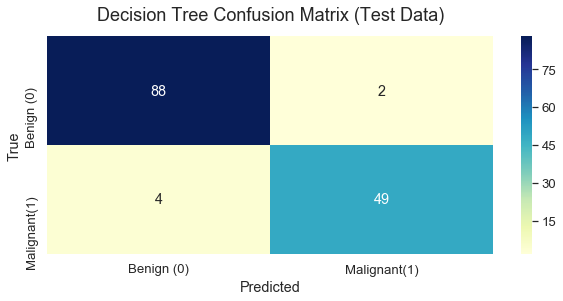

In [474]:
visualized_confusion_matrix(y_test, dt_preds, "Decision Tree Confusion Matrix (Test Data)")

Our Decision Tree model has a __training recall score of 100%__ and a __testing recall score of 92.4%__.  
Unsurprisingly, the Decision Tree model is clearly overfit.


#### Identifying important predictive variables

In [475]:
feature_importances = [pair for pair in list(zip(gs_dt.best_estimator_.feature_importances_, X.columns)) if pair[0] > 0]

In [476]:
len(feature_importances)

9

In [477]:
#Extracting 5 most important features
feature_importances.sort(reverse = True)
feature_importances[:5]

[(0.7593282324975731, 'concavity_worst'),
 (0.10089762101223507, 'fractal_dimension_mean'),
 (0.03979418069255827, 'radius_sd_error'),
 (0.03301584369774632, 'smoothness_mean'),
 (0.02608668622788891, 'concave_points_mean')]

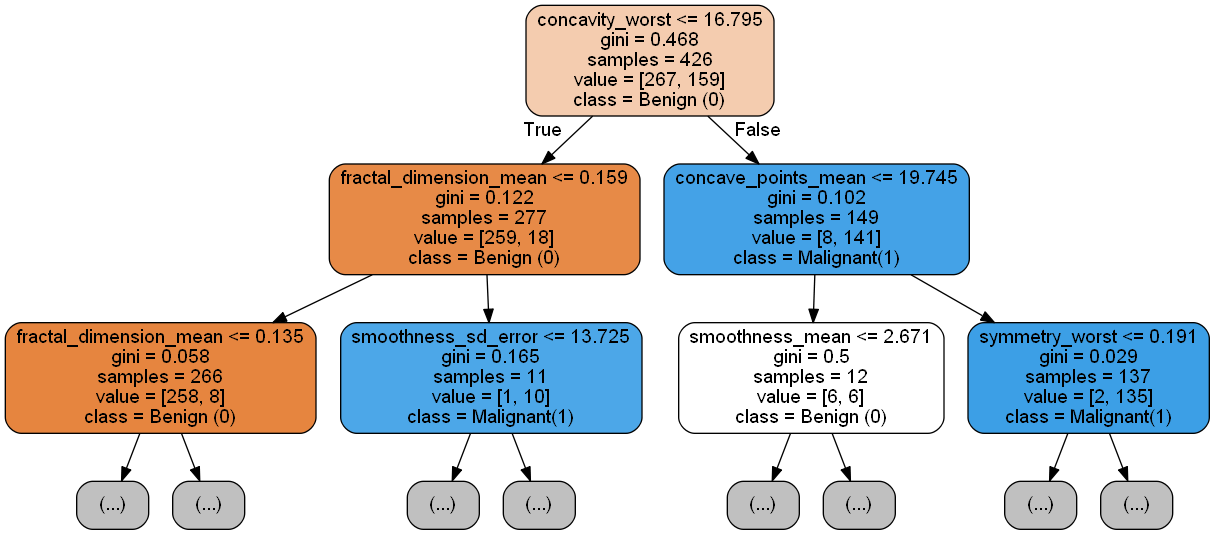

In [478]:
dot_data = StringIO()
export_graphviz(gs_dt.best_estimator_,
                out_file=dot_data,
                feature_names=X.columns,
                class_names=["Benign (0)","Malignant(1)"],
                filled=True,
                rounded=True,
                max_depth= 2
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

We find the Decision Tree model considers the `concavity_worst` feature as most important by a wide margin, followed by `fractal_dimension_mean` and other features of gradually decreasing importance.  

Compared to the exploratory analysis, we see many of the same features, though the relative correlations we saw initially did not translate directly to how significant these features were to the model.

## K Nearest Neighbors (KNN)

#### Advantages
- "Training" is not processor intensive
- Just one hyperparameter `n_neighbors` (though, it could be argued the distance metric is another!)
- Uses instance-based learning, so can quickly adapt to changes "live", making it a good model for production

#### Disadvantages
- "Training" involves storing input data to memory, which can be cumbersome with larger datasets
- Similarly, with more features, KNN models tend to have more difficulty predicting on higher dimensions
- Data MUST be scaled, since KNN is a distance-based model
- Being distance-based, also means this model is very sensative to outliers
- The hyperparameter `n_neighbors` must be defined, which can be difficult to determine without iteratively searching for it, which can be time-consuming
- Not easily interpretable, since the reason for a prediction is simply the "vote" from the nearest neighbors, it's difficult to know how a particular features affects the end result
- Similarly, KNN does not perform well on imbalanced data because of the "voting" nature of the model

#### Controlling for overfitting
Unfortunately, KNN models don't have many options to alter how the model predicts. However, overfitting is somewhat difficult for KNN models because of the "voting" nature of the algorithm. 

In [441]:
knn = KNeighborsClassifier()

knn_params = {
    "n_neighbors": range(1,20),
    "metric": ["minkowski","manhattan"]
}

# Need to scale before using KNN
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)

gs_knn = grid_search_helper(knn, knn_params, ss)

In [442]:
gs_knn.best_params_

{'metric': 'minkowski', 'n_neighbors': 3}

#### Evaluating performance

In [443]:
recall_score(y_train, gs_knn.predict(ss.transform(X_train)))

0.9433962264150944

In [444]:
knn_preds = gs_knn.predict(ss.transform(X_test))

recall_score(y_test, knn_preds)

0.9056603773584906

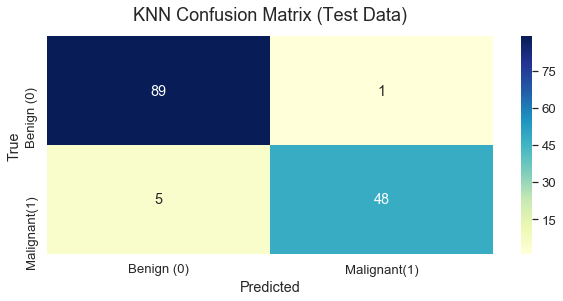

In [445]:
visualized_confusion_matrix(y_test, knn_preds, "KNN Confusion Matrix (Test Data)")

We find the KNN model performs better than the Decision Tree with  a __training recall score of 94.3%__ and a __testing recall score of 90.6%__.

There appears to be some overfitting, but for the most part the KNN model is comparable to the Decision Tree - with less overfitting, but overall having less predictive power.

#### Identifying important predictive variables

As mentioned previously, the KNN model does not make a clear distinction as to which features are most important or by how much.  

## Model Selection

Given the better performance and interpretability of the Decision Tree model, I would select it as the prefered __predictive an interpretive model__.

### Technical Explaination

Only two models were analyzed, both of which showed overfitting. As such, other classification models could show better results. Especially in the case of the Decision Tree, a natural next step would be to attempt a Bagged Tree or Random Forest model to address the overfitting. Additionally, the Decision Tree and KNN models have the potential for better performance since the hyperparameters tuned in the `GridSearchCV` were lightly experimented with.

Another limitation of the analysis is the lack of feature selection and engineering. It's possible features could be removed or created in order to improve model performance. Much of the data science process is iteration, and given more time I would go back and re-evaluate features, models, and hyperparameters.

---

### Non-Technical Explaination
The Decision Tree model works intuitively to split data into distinct subsets. 

If I said, "I'm thinking of a number from 1 to 100, and you can ask if it's higher or lower than another number".   
What would your first question be? "Is it higher or lower than 50?"  
But why 50 and not 2? Well, since we don't know the answer, we want to eliminate as many wrong answers as possible, so 50, being the halfway point, will do just that. An answer of "yes, it's higher" or "no, it's lower" will reduce the number of possible right answer by the most possible, half.

The Decision Tree works like that. In our case, the "questions" asked relate to the features in the data. The first and most important question that reduces the data the most is `concavity_worst`. "Does the observation have a `concavity_worst` with less than or equal to 16.795?" If so, more than likely, the sample is "Benign", and if not, the sample is likely "Malignant". The second most important feature is `fractal_dimension_mean`, with another 8 used by the model in the decision making process.

This model performs with a testing recall score of 92.4%, meaning we can expect it to perform as well on new data. Practically, this performance is not very good, because about 7.6% of observations predicted to be "Benign" are actually "Malignant". 

# Part 2: Student Feedback Challenge

train, test, split for proper evaluation
cross_val OK for quick assessment
Set random state
TEST cross_val_score and scoring="mean_absolute_error"

## Student #1 (Amy)

```python
import pandas as pd
import numpy as np
from sklearn import LinearRegression
from sklearn.cross_validation import cross_val_score

# Load data
d = pd.read_csv('../data/train.csv')

# Setup data for prediction
x1 = data.SalaryNormalized
x2 = pd.get_dummies(data.ContractType)

# Setup model
model = LinearRegression()

# Evaluate model
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
scores = cross_val_score(model, x2, x1, cv=1, scoring='mean_absolute_error')
print(scores.mean())```

---
Hey Amy! 

I just wanted to give you some feedback on the code you sent me.  
Your intention is clear (thank you for the comments!) and I can tell you're getting the gist of what we went over in class. Now its just a matter of execution.

### Importing libraries
Whenever possible, keeping library imports together and at the start is a good practice. This way anyone else looking at your code or wanting to follow along will know all of the dependencies right away.

Also, `cross_val_score` is part of the `sklearn.model_selection` module. I know there are a TON of sklearn modules, and it can be confusing to use the right one. I actually use Tab autocompletion most of the time to figure out what I need. You properly imported `pandas` and `numpy`, though never actually used the `numpy` library. I suggest pruning back any unneeded imports whenever possible to lighten the load on your RAM.

Here's a trimed down group of imports you used:
```python
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
```
Notice how we can import multiple functions from the same module by separating each function name with a comma.


### Variable Naming
Even the most experience programmers struggle with variable names! A good rule of thumb is to use descriptive naming and to be consistent.

For example, you read in the csv file and store it in the variable `d`, but later refer to a `data` variable. While I can understand your intention, the Python interpreter won't be so forgiving. 

Also, when setting up your data for prediction, you use the variables `x1` and `x2`, which may be a convenient way to quickly test what you're doing while coding, but anyone else (or even yourself a week later!) looking at these variables will really struggle to know what's going on. I'd suggest sticking with convention and naming your target variable `y` and the model features as `X` (note the casing).

__A minor consideration:__ _When using_ `pd.get_dummies` _it's recommended to set_ `drop_first = True` _to help reduce overfitting. Remember, more features = more "bendy" model that can better align to the training data._

### `cross_val_score`
This function trips up a lot of students.  
You've properly supplied the model and variables in the correct order.

I noticed you're using a `cv = 1`, which won't actually allow you to take advantage of the power of cross validation (an exception will be thrown). Depending on the size of the data, a good standard is `cv = 5`.

I see you're trying to score using MSE, which is fine, but according to the [scoring parameter documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter), using `scoring='mean_absolute_error'` is not valid. I will suggest importing and using the `mean_squared_error` function from sklearn, but it will require some nuance using `make_scorer`. This will ensure `cross_val_score` and `mean_squared_error` play nicely together. If you're interested in learning more about this or even making your own customize scoring metric, please let me know!

### `train_test_split`
Your intuition to load `train_test_split` was correct, though you never implemented it.  

In class, we discussed the 3 main ways to evaluate a model: 

1. checking the model's bias
2. checking the model's variance
3. checking the validity of the previous 2 results

When you used `cross_val_score`, you're essentially looking at #3, but will still want to create a fitted model and evaluate it on a training and test set. Check out the below solution for how to properly implement a `train_test_split` (_Note how a `random_\__state` is set for reproducibility_).

### Ideal Solution
I prefer to use "bracket" notation (For example, `data["SalaryNormalized"]`), just because if your column names have spaces in them, then the "dot" notation will not work.

```python
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer

# Load data
d = pd.read_csv('../data/train.csv')

# Setup data for prediction
X = pd.get_dummies(data["ContractType"], drop_first = True)
y = data["SalaryNormalized"]

# Setup model
model = LinearRegression()

# Model preparation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

##################
# Evaluate model #
##################
# Checking for bias
bias_check = mean_squared_error(y_train, model.predict(X_train))
print("Training MSE: ", bias_check)

# Checking for variance
variance_check = mean_squared_error(y_test, model.predict(X_test))
print("Testing MSE: ", variance_check)

# Checking for validity of previous 2 evaluations
cross_val_check = cross_val_score(lr, X, y, cv = 5, scoring = make_scorer(mean_squared_error)).mean()
print("Cross Val MSE:", cross_val_check)
```

## Overall:
It looks like you have most of the pieces in mind, but could use more practice putting everything together. Let's chat briefly during our 1-on-1 about how we can best set you up for success.

---

## Student #2 (Billy)

```python
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score

# Load data
data = pd.read_csv('../data/train.csv')

# Setup data for prediction
y = data.SalaryNormalized
X = pd.get_dummies(data.ContractType)

# Setup model
model = LinearRegression()

# Evaluate model
scores = cross_val_score(model, X, y, cv=5, scoring='mean_absolute_error')
print(scores.mean())```

---
Hey Billy! 

I just wanted to give you some feedback on the code you sent me.  
I can tell you're really getting a good grasp of proper workflow and how to execute it.
With that said, I have a few bits of feedback for you to consider.

### Importing libraries
Well done, keeping library imports together and at the start. This is a good practice and helps anyone else looking at your code or wanting to follow along will know all of the dependencies right away.

Also, `cross_val_score` is part of the `sklearn.model_selection` module. I know there are a TON of sklearn modules, and it can be confusing to use the right one. I actually use Tab autocompletion most of the time to figure out what I need. You properly imported `pandas` and `numpy`, though never actually used the `numpy` library. I suggest pruning back any unneeded imports whenever possible to lighten the load on your RAM.

Here's a trimed down group of imports you used:
```python
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
```

### Variable Naming
You use descriptive variable naming and are consistent. Also, well done sticking with convention and naming your target variable `y` and the model features as `X`.

__A minor consideration:__ _When using_ `pd.get_dummies` _it's recommended to set_ `drop_first = True` _to help reduce overfitting. Remember, more features = more "bendy" model that can better align to the training data._

### `cross_val_score`
This function trips up a lot of students.  
You've properly supplied the model and variables in the correct order.

You're using a good K-fold of `cv = 5`.

I see you're trying to score using MSE, which is fine, but according to the [scoring parameter documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter), using `scoring='mean_absolute_error'` is not valid. I will suggest importing and using the `mean_squared_error` function from sklearn, but it will require some nuance using `make_scorer`. This will ensure `cross_val_score` and `mean_squared_error` play nicely together. If you're interested in learning more about this or even making your own customize scoring metric, please let me know!

### `train_test_split`
In class, we discussed the 3 main ways to evaluate a model: 

1. checking the model's bias
2. checking the model's variance
3. checking the validity of the previous 2 results

When you used `cross_val_score`, you're essentially looking at #3, but will still want to create a fitted model and evaluate it on a training and test set. Check out the below solution for how to properly implement a `train_test_split` (_Note how a `random_\__state` is set for reproducibility_).

### Ideal Solution
Notice how we can import multiple functions from the same module by separating each function name with a comma.

Also, I prefer to use "bracket" notation (For example, `data["SalaryNormalized"]`), just because if your column names have spaces in them, then the "dot" notation will not work.

```python
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer

# Load data
d = pd.read_csv('../data/train.csv')

# Setup data for prediction
X = pd.get_dummies(data["ContractType"], drop_first = True)
y = data["SalaryNormalized"]

# Setup model
model = LinearRegression()

# Model preparation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

##################
# Evaluate model #
##################
# Checking for bias
bias_check = mean_squared_error(y_train, model.predict(X_train))
print("Training MSE: ", bias_check)

# Checking for variance
variance_check = mean_squared_error(y_test, model.predict(X_test))
print("Testing MSE: ", variance_check)

# Checking for validity of previous 2 evaluations
cross_val_check = cross_val_score(lr, X, y, cv = 5, scoring = make_scorer(mean_squared_error)).mean()
print("Cross Val MSE:", cross_val_check)
```

## Overall:
It looks like you have strong understanding of the workflow and executing code. There are some concepts you may want some more practice with, so let's chat briefly during our 1-on-1 about how we can best set you up for success.

---